#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/project/'

### **(2) 라이브러리 설치 및 불러오기**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential, Model
from keras.backend import clear_session
from keras.layers import *
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [7]:
!pip install workalendar
from workalendar.usa.minnesota import Minnesota
import datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732001 sha256=6c4a2616a67cea3bab76f2bf27ac3dba8a51de58dd7100556b028b454302eb39
  Stored in directory: /root/.cache/pip/wheels/d6/67/78/aa2e8d108639dd23a5e9e72a4fc88bb44f5541894382712f48
Successfully built pymeeus


In [8]:
def make_3_data( orders, sales, oil_price, leadTime, s_year, e_year, x_scaler, y_scaler, fit=False ):
    # 1. 데이터 준비: 'Qty', 'WTI_Price', 'CustomerCount', 'Date', 'Store_ID', 'Product_ID'
    orders = orders.loc[orders['Store_ID']==44].reset_index(drop=True)
    sales = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==3)].reset_index(drop=True)
    df = sales.merge(oil_price, how='left', on='Date')\
    .merge(orders, how='left', on=['Date','Store_ID'])
    # 'target'
    df['target'] = df['Qty'].shift(-leadTime)
    # 결측치 처리
    df['WTI_Price'] = df['WTI_Price'].fillna(method='ffill')
    df['Qty'] = df['Qty'].interpolate(method='linear')
    df['CustomerCount'] = df['CustomerCount'].interpolate(method='linear')
    df.dropna(inplace = True)

    # 2. 컬럼 추가: 'year', 'month', 'weekday', 'season', holiday'
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['weekday'] = df['Date'].dt.dayofweek
    df['season'] = np.where(df['month'].isin([3,4,5]), 'Spring',
                        np.where(df['month'].isin([6,7,8]), 'Summer',
                                 np.where(df['month'].isin([9,10,11]), 'Fall',
                                          'Winter')))
    df['season'] = pd.Categorical(df['season'], categories=['Spring','Summer','Fall','Winter'])
    cal = Minnesota()
    holiday = pd.DataFrame()
    for y in range(s_year, e_year):
        holiday = pd.concat([holiday,pd.DataFrame(cal.holidays(y))], axis=0)
    holiday.columns = ['Date', 'holiday']
    holiday['Date'] = pd.to_datetime(holiday['Date']) - datetime.timedelta(days=2)
    holiday['holiday'] = 1
    df = df.merge(holiday, how='left', on='Date')
    df['holiday'] = df['holiday'].fillna(0).astype('bool')

    # 3. 필요없는 행 제거: 'Date', 'Store_ID', 'Product_ID'
    df.sort_values(by='Date', inplace=True)
    df = df.drop(['Date', 'Store_ID', 'Product_ID'], axis=1)

    # 4. 가변수화: 'season'
    df = pd.get_dummies(df,columns=['season'], drop_first=True)
    df['year'] = df['year'] - 2013
    df['month'] = df['month'].astype(int)
    df['weekday'] = df['weekday'].astype(int)

    # 5. x,y 분리 및 스케일링: fit 여부
    x_test = np.array(df.drop('target', axis=1))
    y_test = df.loc[:,'target'].values.reshape(-1, 1)
    if fit == True:
      x_scaler.fit(x_test)
      y_scaler.fit(y_test)
    y_test = y_scaler.transform(y_test)
    x_test = x_scaler.transform(x_test)

    return x_test, y_test

In [9]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x, y
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [10]:
from sklearn.preprocessing import MinMaxScaler
x_mm = MinMaxScaler()
y_mm = MinMaxScaler()

In [11]:
X, y = make_3_data(orders, sales, oil_price, 2, 2014, 2018, x_mm, y_mm, fit=True)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=60, shuffle=False)

In [13]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [14]:
X_tem_train, y_tem_train = temporalize(pd.DataFrame(X_train), pd.DataFrame(y_train), 7)
X_tem_valid, y_tem_valid = temporalize(pd.DataFrame(X_valid), pd.DataFrame(y_valid), 7)

## **(1) LSTM 모델링**

### **1) 상품 : 3 - Beverage**

* **모델링**

#### LSTM(128)

In [29]:
timesteps = 7
n_features = X_tem_train.shape[2]

il = Input(shape=(timesteps, n_features))
hl = LSTM(128)(il)
ol = Dense(1)(hl)

model_3_base = Model(il, ol)

In [30]:
model_3_base.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mse'])

history_3_base = model_3_base.fit(X_tem_train, y_tem_train, epochs=100, batch_size=32, validation_data=(X_tem_valid, y_tem_valid), verbose=1).history

Epoch 1/100
34/34 [==============================] - 2s 33ms/step - loss: 0.0252 - mae: 0.1229 - mse: 0.0252 - val_loss: 0.0222 - val_mae: 0.1317 - val_mse: 0.0222
Epoch 2/100
34/34 [==============================] - 1s 17ms/step - loss: 0.0154 - mae: 0.0951 - mse: 0.0154 - val_loss: 0.0190 - val_mae: 0.1101 - val_mse: 0.0190
Epoch 3/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0128 - mae: 0.0865 - mse: 0.0128 - val_loss: 0.0171 - val_mae: 0.1195 - val_mse: 0.0171
Epoch 4/100
34/34 [==============================] - 1s 17ms/step - loss: 0.0104 - mae: 0.0769 - mse: 0.0104 - val_loss: 0.0259 - val_mae: 0.1420 - val_mse: 0.0259
Epoch 5/100
34/34 [==============================] - 0s 15ms/step - loss: 0.0094 - mae: 0.0725 - mse: 0.0094 - val_loss: 0.0136 - val_mae: 0.1029 - val_mse: 0.0136
Epoch 6/100
34/34 [==============================] - 0s 8ms/step - loss: 0.0088 - mae: 0.0698 - mse: 0.0088 - val_loss: 0.0122 - val_mae: 0.0960 - val_mse: 0.0122
Epoch 7/100
34/34

In [31]:
y_3_base_pred = model_3_base.predict(X_tem_valid)

2/2 [==============================] - 0s 6ms/step


In [32]:
y_valid_org = y_mm.inverse_transform(y_tem_valid.reshape(-1, 1))
y_3_base_pred = y_mm.inverse_transform(y_3_base_pred.reshape(-1, 1))

In [33]:
print('RMSE :', mean_squared_error(y_valid_org, y_3_base_pred) ** 0.5)
print('MAE :', mean_absolute_error(y_valid_org, y_3_base_pred))
print('MAPE:', mean_absolute_percentage_error(y_valid_org, y_3_base_pred))
print('R2  :', r2_score(y_valid_org, y_3_base_pred))

RMSE : 2362.5185971082333
MAE : 1934.5714518229167
MAPE: 0.18265626944665228
R2  : 0.5864149403160157


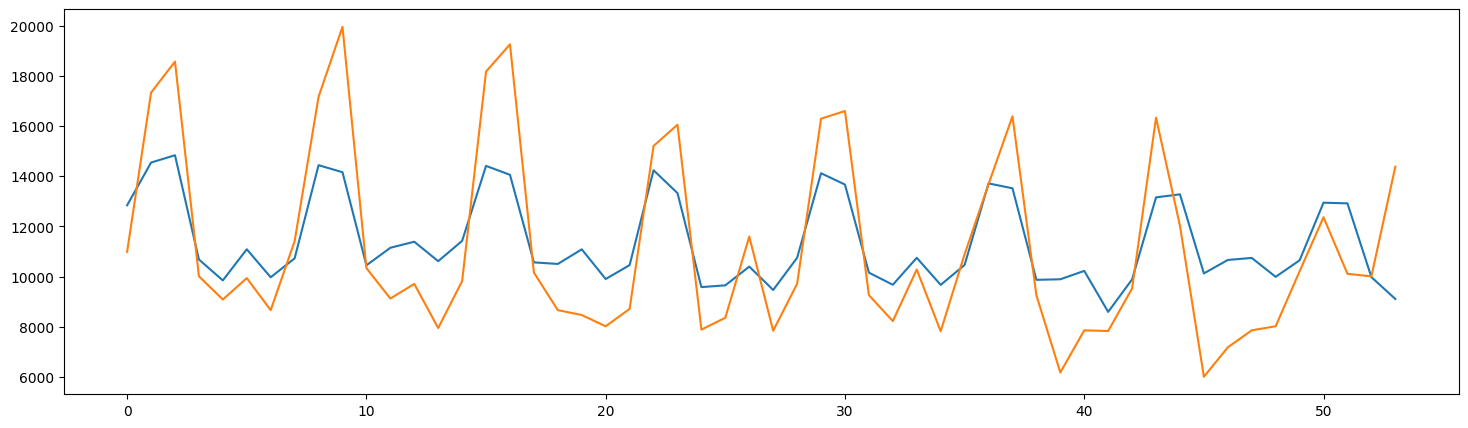

In [34]:
plt.figure(figsize=(18, 5))
plt.plot(range(len(y_3_base_pred)), y_3_base_pred)
plt.plot(range(len(y_3_base_pred)), y_valid_org)
plt.show()

#### LSTM 레이어추가 1

In [131]:
il = Input(shape=(timesteps, n_features))
hl = LSTM(128, return_sequences=True)(il)
hl = LSTM(128, return_sequences=True)(hl)
hl = LSTM(96, return_sequences=True)(hl)
hl = LSTM(24)(hl)
ol = Dense(1)(hl)

model_3_1 = Model(il, ol)

In [132]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10,verbose=1,restore_best_weights=True)

In [133]:
model_3_1.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mse'])

history_3_1 = model_3_1.fit(X_tem_train, y_tem_train, epochs=100, batch_size=32, validation_data=(X_tem_valid, y_tem_valid), verbose=1, callbacks=[es]).history

Epoch 1/100
34/34 [==============================] - 6s 56ms/step - loss: 0.0251 - mae: 0.1196 - mse: 0.0251 - val_loss: 0.0215 - val_mae: 0.1002 - val_mse: 0.0215
Epoch 2/100
34/34 [==============================] - 1s 23ms/step - loss: 0.0137 - mae: 0.0908 - mse: 0.0137 - val_loss: 0.0187 - val_mae: 0.0940 - val_mse: 0.0187
Epoch 3/100
34/34 [==============================] - 1s 26ms/step - loss: 0.0121 - mae: 0.0838 - mse: 0.0121 - val_loss: 0.0131 - val_mae: 0.0868 - val_mse: 0.0131
Epoch 4/100
34/34 [==============================] - 1s 39ms/step - loss: 0.0118 - mae: 0.0808 - mse: 0.0118 - val_loss: 0.0166 - val_mae: 0.0923 - val_mse: 0.0166
Epoch 5/100
34/34 [==============================] - 1s 30ms/step - loss: 0.0100 - mae: 0.0750 - mse: 0.0100 - val_loss: 0.0171 - val_mae: 0.0942 - val_mse: 0.0171
Epoch 6/100
34/34 [==============================] - 1s 23ms/step - loss: 0.0094 - mae: 0.0714 - mse: 0.0094 - val_loss: 0.0123 - val_mae: 0.0824 - val_mse: 0.0123
Epoch 7/100
34/3

In [134]:
y_3_1_pred = model_3_1.predict(X_tem_valid)

2/2 [==============================] - 1s 9ms/step


In [135]:
y_3_1_pred = y_mm.inverse_transform(y_3_1_pred.reshape(-1, 1))

In [136]:
print('RMSE :', mean_squared_error(y_valid_org, y_3_1_pred) ** 0.5)
print('MAE :', mean_absolute_error(y_valid_org, y_3_1_pred))
print('MAPE:', mean_absolute_percentage_error(y_valid_org, y_3_1_pred))
print('R2  :', r2_score(y_valid_org, y_3_1_pred))

RMSE : 1926.0125521522878
MAE : 1421.4643916377315
MAPE: 0.12518515351221607
R2  : 0.72512667456415


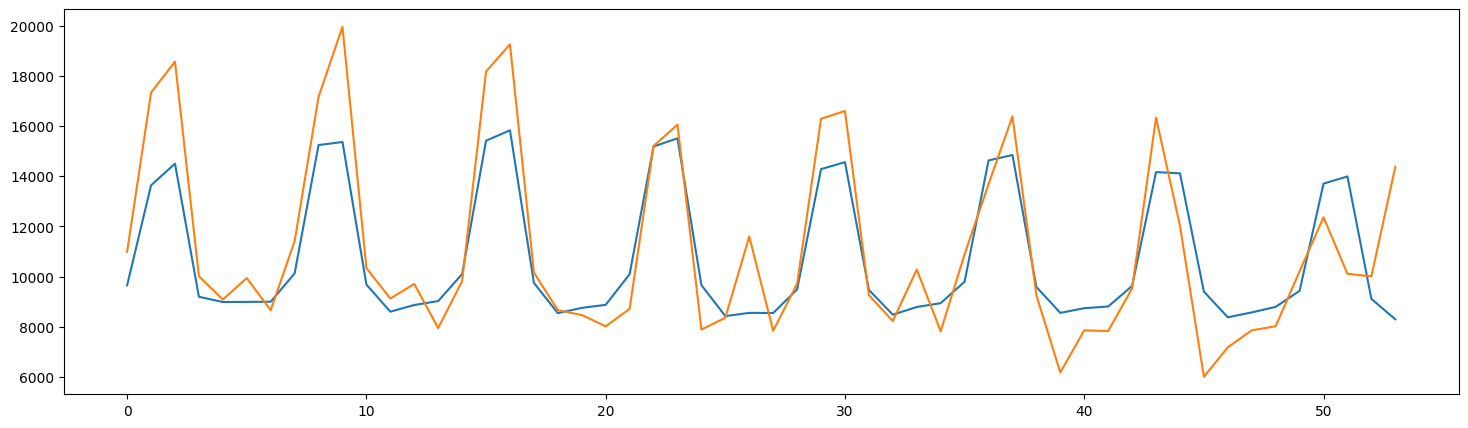

In [137]:
plt.figure(figsize=(18, 5))
plt.plot(range(len(y_3_1_pred)), y_3_1_pred)
plt.plot(range(len(y_3_1_pred)), y_valid_org)
plt.show()

#### LSTM 레이어추가 2

In [164]:
il = Input(shape=(timesteps, n_features))
hl = LSTM(256, return_sequences=True)(il)
hl = LSTM(256, return_sequences=True)(hl)
hl = Dropout(0.2)(hl)
hl = LSTM(128, return_sequences=True)(hl)
hl = LSTM(128, return_sequences=True)(hl)
hl = Dropout(0.2)(hl)
hl = LSTM(96, return_sequences=True)(hl)
hl = LSTM(24)(hl)
ol = Dense(1)(hl)

model_3_2 = Model(il, ol)

In [165]:
model_3_2.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mse'])

history_3_2 = model_3_2.fit(X_tem_train, y_tem_train, epochs=100, batch_size=32, validation_data=(X_tem_valid, y_tem_valid), verbose=1, callbacks=[es]).history

Epoch 1/100
34/34 [==============================] - 11s 130ms/step - loss: 0.0293 - mae: 0.1291 - mse: 0.0293 - val_loss: 0.0213 - val_mae: 0.1003 - val_mse: 0.0213
Epoch 2/100
34/34 [==============================] - 3s 77ms/step - loss: 0.0148 - mae: 0.0945 - mse: 0.0148 - val_loss: 0.0297 - val_mae: 0.1227 - val_mse: 0.0297
Epoch 3/100
34/34 [==============================] - 2s 70ms/step - loss: 0.0124 - mae: 0.0853 - mse: 0.0124 - val_loss: 0.0243 - val_mae: 0.1144 - val_mse: 0.0243
Epoch 4/100
34/34 [==============================] - 2s 70ms/step - loss: 0.0125 - mae: 0.0847 - mse: 0.0125 - val_loss: 0.0328 - val_mae: 0.1422 - val_mse: 0.0328
Epoch 5/100
34/34 [==============================] - 2s 70ms/step - loss: 0.0128 - mae: 0.0853 - mse: 0.0128 - val_loss: 0.0172 - val_mae: 0.0965 - val_mse: 0.0172
Epoch 6/100
34/34 [==============================] - 3s 92ms/step - loss: 0.0098 - mae: 0.0747 - mse: 0.0098 - val_loss: 0.0122 - val_mae: 0.0839 - val_mse: 0.0122
Epoch 7/100
34

In [166]:
y_3_2_pred = model_3_2.predict(X_tem_valid)

2/2 [==============================] - 4s 36ms/step


In [167]:
y_3_2_pred = y_mm.inverse_transform(y_3_2_pred.reshape(-1, 1))

In [168]:
print('RMSE :', mean_squared_error(y_valid_org, y_3_2_pred) ** 0.5)
print('MAE :', mean_absolute_error(y_valid_org, y_3_2_pred))
print('MAPE:', mean_absolute_percentage_error(y_valid_org, y_3_2_pred))
print('R2  :', r2_score(y_valid_org, y_3_2_pred))

RMSE : 1963.8328641788373
MAE : 1460.2558051215278
MAPE: 0.1357682188187592
R2  : 0.7142255369914705


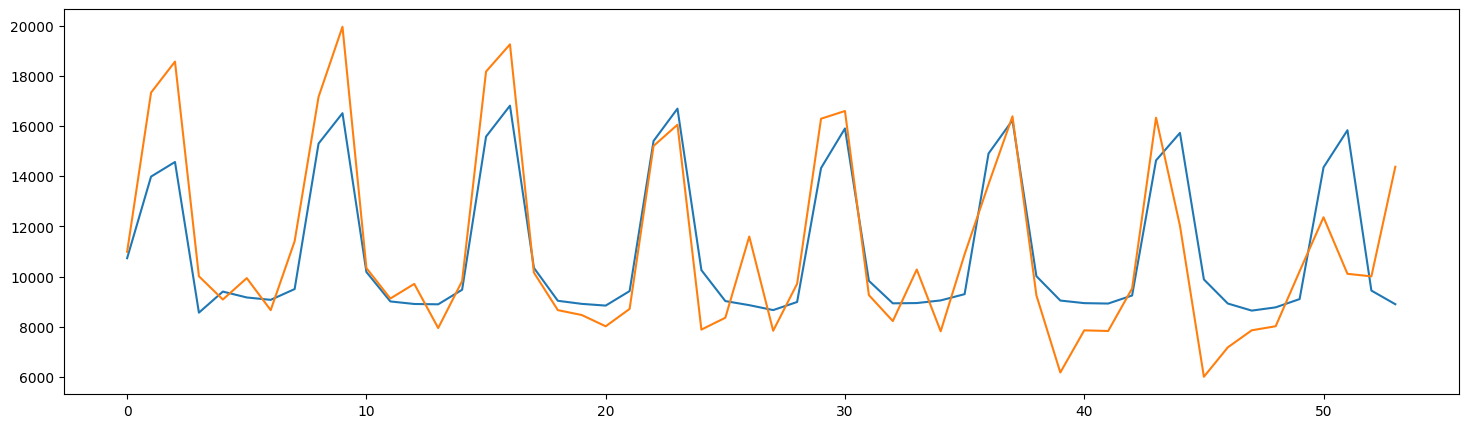

In [169]:
plt.figure(figsize=(18, 5))
plt.plot(range(len(y_3_2_pred)), y_3_2_pred)
plt.plot(range(len(y_3_2_pred)), y_valid_org)
plt.show()

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x, y
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

In [ ]:
def make_3_data( orders, sales, oil_price, leadTime, s_year, e_year, x_scaler, y_scaler, fit=False ):
    # 1. 데이터 준비: 'Qty', 'WTI_Price', 'CustomerCount', 'Date', 'Store_ID', 'Product_ID'
    orders = orders.loc[orders['Store_ID']==44].reset_index(drop=True)
    sales = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==3)].reset_index(drop=True)
    df = sales.merge(oil_price, how='left', on='Date')\
    .merge(orders, how='left', on=['Date','Store_ID'])
    # 'target'
    df['target'] = df['Qty'].shift(-leadTime)
    # 결측치 처리
    df['WTI_Price'] = df['WTI_Price'].fillna(method='ffill')
    df['Qty'] = df['Qty'].interpolate(method='linear')
    df['CustomerCount'] = df['CustomerCount'].interpolate(method='linear')
    df.dropna(inplace = True)

    # 2. 컬럼 추가: 'year', 'month', 'weekday', 'season', holiday'
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['weekday'] = df['Date'].dt.dayofweek
    df['season'] = np.where(df['month'].isin([3,4,5]), 'Spring',
                        np.where(df['month'].isin([6,7,8]), 'Summer',
                                 np.where(df['month'].isin([9,10,11]), 'Fall',
                                          'Winter')))
    df['season'] = pd.Categorical(df['season'], categories=['Spring','Summer','Fall','Winter'])
    cal = Minnesota()
    holiday = pd.DataFrame()
    for y in range(s_year, e_year):
        holiday = pd.concat([holiday,pd.DataFrame(cal.holidays(y))], axis=0)
    holiday.columns = ['Date', 'holiday']
    holiday['Date'] = pd.to_datetime(holiday['Date']) - datetime.timedelta(days=2)
    holiday['holiday'] = 1
    df = df.merge(holiday, how='left', on='Date')
    df['holiday'] = df['holiday'].fillna(0).astype('bool')

    # 3. 필요없는 행 제거: 'Date', 'Store_ID', 'Product_ID'
    df.sort_values(by='Date', inplace=True)
    df = df.drop(['Date', 'Store_ID', 'Product_ID'], axis=1)

    # 4. 가변수화: 'season'
    df = pd.get_dummies(df,columns=['season'], drop_first=True)
    df['year'] = df['year'] - 2013
    df['month'] = df['month'].astype(int)
    df['weekday'] = df['weekday'].astype(int)

    # 5. x,y 분리 및 스케일링: fit 여부
    x_test = np.array(df.drop('target', axis=1))
    y_test = df.loc[:,'target'].values.reshape(-1, 1)
    if fit == True:
      x_scaler.fit(x_test)
      y_scaler.fit(y_test)
    y_test = y_scaler.transform(y_test)
    x_test = x_scaler.transform(x_test)

    return x_test, y_test

## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [109]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

In [112]:
x_test, y_test = make_3_data( orders_test, sales_test, oil_price_test, 2, 2017, 2018, x_mm, y_mm )

In [113]:
x_test.shape, y_test.shape

((29, 10), (29, 1))

In [115]:
X_tem_test, y_tem_test = temporalize(pd.DataFrame(x_test), pd.DataFrame(y_test), 7)

* 예측해보기

In [ ]:
y_test_org = y_mm.inverse_transform(y_tem_test)

#### 1

In [139]:
y_3_1_tpred = model_3_1.predict(X_tem_test)

1/1 [==============================] - 0s 18ms/step


In [140]:
y_3_1_tpred = y_mm.inverse_transform(y_3_1_tpred.reshape(-1, 1))

In [141]:
print('RMSE :', mean_squared_error(y_test_org, y_3_1_tpred) ** 0.5)
print('MAE :', mean_absolute_error(y_test_org, y_3_1_tpred))
print('MAPE:', mean_absolute_percentage_error(y_test_org, y_3_1_tpred))
print('R2  :', r2_score(y_test_org, y_3_1_tpred))

RMSE : 1428.7765227519626
MAE : 1029.3877377717392
MAPE: 0.08739195905914021
R2  : 0.883974399126433


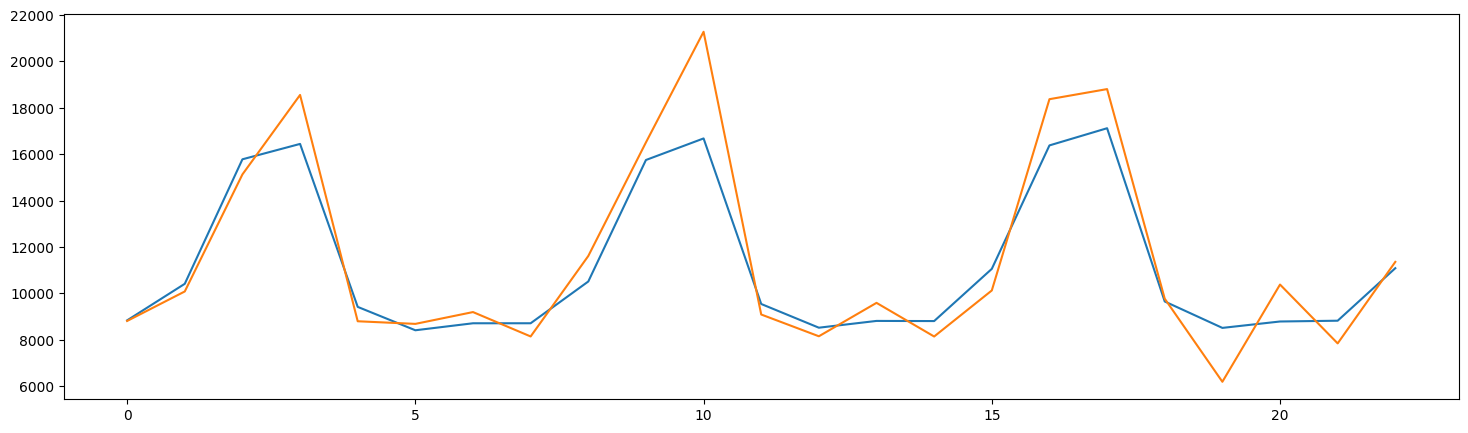

In [142]:
plt.figure(figsize=(18, 5))
plt.plot(range(len(y_3_1_tpred)), y_3_1_tpred)
plt.plot(range(len(y_3_1_tpred)), y_test_org)
plt.show()

#### 2

In [170]:
y_3_2_tpred = model_3_2.predict(X_tem_test)

1/1 [==============================] - 0s 50ms/step


In [171]:
y_3_2_tpred = y_mm.inverse_transform(y_3_2_tpred.reshape(-1, 1))

In [172]:
print('RMSE :', mean_squared_error(y_test_org, y_3_2_tpred) ** 0.5)
print('MAE :', mean_absolute_error(y_test_org, y_3_2_tpred))
print('MAPE:', mean_absolute_percentage_error(y_test_org, y_3_2_tpred))
print('R2  :', r2_score(y_test_org, y_3_2_tpred))

RMSE : 1722.849294425747
MAE : 1321.1179093070652
MAPE: 0.11362595490237594
R2  : 0.8312981697996278


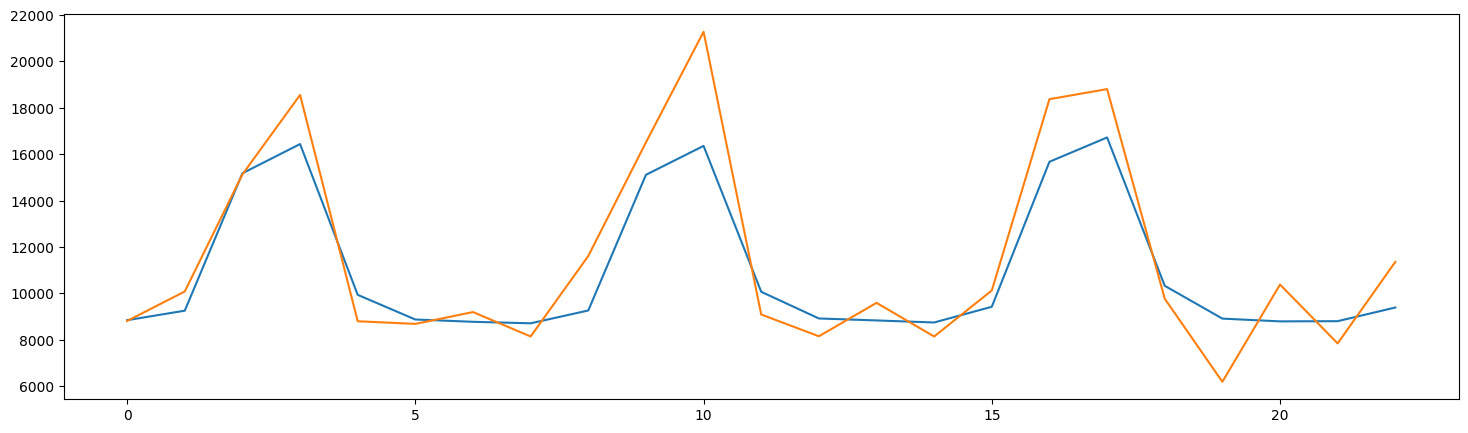

In [173]:
plt.figure(figsize=(18, 5))
plt.plot(range(len(y_3_2_tpred)), y_3_2_tpred)
plt.plot(range(len(y_3_2_tpred)), y_test_org)
plt.show()

# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [143]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


In [157]:
inv_simulator(y_test_org, y_3_1_tpred, 7590, 8)

일평균 재고량     : 13476.667
일평균 재고 금액  : 107813.336
일평균 재고회전율 : 0.942
기회손실 수량     : 0.0


,y,pred,base_stock,close_stock,order,receive,lost
0,8816.0,8842.0,16406,7590,15782,8816,0.0
1,10087.0,10417.0,17677,7590,16445,10087,0.0
2,15131.0,15782.0,23372,8241,8771,15782,0.0
3,18556.0,16445.0,24686,6130,9875,16445,0.0
4,8803.0,9422.0,14901,6098,10208,8771,0.0
5,8690.0,8415.0,15973,7283,9024,9875,0.0
6,9199.0,8716.0,17491,8292,9815,10208,0.0
7,8148.0,8717.0,17316,9168,14174,9024,0.0
8,11616.0,10517.0,18983,7367,16905,9815,0.0
9,16510.0,15752.0,21541,5031,12106,14174,0.0


In [187]:
inv_simulator(y_test_org, y_3_2_tpred, 10850, 8)

일평균 재고량     : 16822.238
일평균 재고 금액  : 134577.904
일평균 재고회전율 : 0.779
기회손실 수량     : 0.0


,y,pred,base_stock,close_stock,order,receive,lost
0,8816.0,8849.0,19666,10850,15180,8816,0.0
1,10087.0,9259.0,20937,10850,16439,10087,0.0
2,15131.0,15180.0,26030,10899,9892,15180,0.0
3,18556.0,16439.0,27338,8782,10946,16439,0.0
4,8803.0,9941.0,18674,9871,9759,9892,0.0
5,8690.0,8878.0,20817,12127,7438,10946,0.0
6,9199.0,8780.0,21886,12687,7431,9759,0.0
7,8148.0,8715.0,20125,11977,13986,7438,0.0
8,11616.0,9268.0,19408,7792,19419,7431,0.0
9,16510.0,15113.0,21778,5268,15656,13986,0.0
